# Bibliotecas

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import math

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import  to_categorical
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier


# Ignorar Avisos desnecessários
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Confere se temos GPU instalada

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.experimental.list_physical_devices())

Num GPUs Available:  1


# Funções Auxiliares

In [36]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, f1, 'k', label='Training F1 Score')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.plot(x, val_f1, 'g', label='Validation F1 Score')
    plt.title('Training and validation Accuracy / F1')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)
        
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Análise dos Dados

## Carregando a base de dados

In [4]:
df = pd.read_csv("./data/pulsar_stars.csv", header=0, names=['MIP', 'SDIP', 'EKIP', 'SIP', 'MDM-SNR', 'SDDM-SNR', 'EKDM-SNR', 'SDM-SNR', 'target'])

In [5]:
df.head()

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MIP       17898 non-null  float64
 1   SDIP      17898 non-null  float64
 2   EKIP      17898 non-null  float64
 3   SIP       17898 non-null  float64
 4   MDM-SNR   17898 non-null  float64
 5   SDDM-SNR  17898 non-null  float64
 6   EKDM-SNR  17898 non-null  float64
 7   SDM-SNR   17898 non-null  float64
 8   target    17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [7]:
df.describe()

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


In [8]:
fig = px.bar(df, x=['0', '1'], y=df.groupby('target').count().MIP,
             labels={'y':'quantidade de estrelas', 'x': 'target'})
fig.update_layout(title_text='Distribuição da variável Target')
fig.show()

In [40]:
def criar_sublistas(lista, subs):
    tam = len(lista)
    res = []
    res_df = pd.DataFrame()
    for i in range(0, tam, subs):
        tmp = lista[i:i+subs]
        if (len(tmp) == subs):
            res.append(tmp.mean())
    return res
         
c = round(df.groupby('target').count().MIP)
print(c[0], c[1])
subs = math.ceil(c[0]/c[1])
negativas = df[df.target == 0]
negativas = criar_sublistas(negativas, subs)
print(negativas[:5])
len(negativas)

16259 1639
[MIP         112.950781
SDIP         47.918933
EKIP          0.241014
SIP           0.235100
MDM-SNR       2.308779
SDDM-SNR     16.581414
EKDM-SNR     10.721943
SDM-SNR     154.611295
target        0.000000
dtype: float64, MIP         122.826562
SDIP         49.221999
EKIP          0.077544
SIP           0.017286
MDM-SNR       4.718562
SDDM-SNR     24.909668
EKDM-SNR      7.806080
SDM-SNR      81.871273
target        0.000000
dtype: float64, MIP         112.427344
SDIP         49.117316
EKIP          0.202946
SIP           0.058117
MDM-SNR       3.173913
SDDM-SNR     19.209042
EKDM-SNR      9.373305
SDM-SNR     111.543404
target        0.000000
dtype: float64, MIP         121.482812
SDIP         46.729040
EKIP          0.098601
SIP           0.324605
MDM-SNR       2.380853
SDDM-SNR     16.975910
EKDM-SNR     10.749121
SDM-SNR     154.253410
target        0.000000
dtype: float64, MIP         116.225781
SDIP         48.677019
EKIP          0.226620
SIP           0.109116
MDM-

1625

In [41]:
df_tst = pd.DataFrame()
df_tst = pd.concat(negativas, ignore_index=True, axis=1).T
df_tst

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,112.950781,47.918933,0.241014,0.235100,2.308779,16.581414,10.721943,154.611295,0.0
1,122.826562,49.221999,0.077544,0.017286,4.718562,24.909668,7.806080,81.871273,0.0
2,112.427344,49.117316,0.202946,0.058117,3.173913,19.209042,9.373305,111.543404,0.0
3,121.482812,46.729040,0.098601,0.324605,2.380853,16.975910,10.749121,154.253410,0.0
4,116.225781,48.677019,0.226620,0.109116,2.432358,17.298481,10.144861,127.757623,0.0
...,...,...,...,...,...,...,...,...,...
1620,111.690625,46.934039,0.215711,0.321320,16.111789,34.533356,7.078829,78.093823,0.0
1621,117.635156,49.079374,0.234606,0.107255,4.347492,22.373660,8.792710,98.365991,0.0
1622,114.566406,43.731026,0.276497,1.037177,2.783863,18.012064,11.382899,171.067199,0.0
1623,116.150000,47.684957,0.212700,0.291412,3.907023,20.858949,9.947946,137.493596,0.0


In [42]:
positivas = df[df.target == 1]
df_final = pd.concat([df_tst, positivas])
df_final

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,112.950781,47.918933,0.241014,0.235100,2.308779,16.581414,10.721943,154.611295,0.0
1,122.826562,49.221999,0.077544,0.017286,4.718562,24.909668,7.806080,81.871273,0.0
2,112.427344,49.117316,0.202946,0.058117,3.173913,19.209042,9.373305,111.543404,0.0
3,121.482812,46.729040,0.098601,0.324605,2.380853,16.975910,10.749121,154.253410,0.0
4,116.225781,48.677019,0.226620,0.109116,2.432358,17.298481,10.144861,127.757623,0.0
...,...,...,...,...,...,...,...,...,...
17515,89.867188,47.482295,1.591325,2.505057,0.763378,12.393561,17.940745,333.902630,1.0
17529,27.039062,33.754722,4.779124,26.255357,129.863712,78.815440,-0.348492,-0.893791,1.0
17558,77.070312,39.000638,1.884421,6.372178,38.517559,65.741059,1.589513,1.285346,1.0
17642,28.375000,27.649311,6.377273,45.944048,141.860368,82.893017,-0.477222,-1.067880,1.0


In [9]:
df_final = df

In [43]:
fig = px.scatter_matrix(df_final, dimensions=['MIP', 'SDIP', 'EKIP', 'SIP', 'MDM-SNR', 'SDDM-SNR', 'EKDM-SNR', 'SDM-SNR'], color="target")
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.update_layout(title='Iris Data set', width=1200, height=1200)
fig.show()

In [44]:
corr = df_final.iloc[:,0:8].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR
MIP,1.00,0.74,-0.96,-0.87,-0.68,-0.75,0.80,0.69
SDIP,0.74,1.00,-0.81,-0.82,-0.33,-0.49,0.53,0.50
EKIP,-0.96,-0.81,1.00,0.97,0.66,0.73,-0.76,-0.66
SIP,-0.87,-0.82,0.97,1.00,0.60,0.62,-0.66,-0.56
MDM-SNR,-0.68,-0.33,0.66,0.60,1.00,0.79,-0.77,-0.58
SDDM-SNR,-0.75,-0.49,0.73,0.62,0.79,1.00,-0.93,-0.80
EKDM-SNR,0.80,0.53,-0.76,-0.66,-0.77,-0.93,1.00,0.94
SDM-SNR,0.69,0.50,-0.66,-0.56,-0.58,-0.80,0.94,1.00


In [45]:
X = df_final.iloc[:,0:8].to_numpy()
X[:10]

array([[ 1.12950781e+02,  4.79189331e+01,  2.41013884e-01,
         2.35099994e-01,  2.30877926e+00,  1.65814140e+01,
         1.07219431e+01,  1.54611295e+02],
       [ 1.22826562e+02,  4.92219992e+01,  7.75444434e-02,
         1.72862243e-02,  4.71856187e+00,  2.49096679e+01,
         7.80608041e+00,  8.18712730e+01],
       [ 1.12427344e+02,  4.91173165e+01,  2.02946384e-01,
         5.81168050e-02,  3.17391304e+00,  1.92090420e+01,
         9.37330479e+00,  1.11543404e+02],
       [ 1.21482812e+02,  4.67290396e+01,  9.86012275e-02,
         3.24605424e-01,  2.38085284e+00,  1.69759095e+01,
         1.07491208e+01,  1.54253410e+02],
       [ 1.16225781e+02,  4.86770186e+01,  2.26619949e-01,
         1.09115748e-01,  2.43235786e+00,  1.72984810e+01,
         1.01448609e+01,  1.27757623e+02],
       [ 1.18429688e+02,  4.89921795e+01,  2.32732414e-01,
         2.45563827e-01,  3.99489967e+00,  1.91570600e+01,
         1.09159718e+01,  1.72104672e+02],
       [ 1.19391406e+02,  5.000659

In [46]:
y = df_final.target.to_numpy()
y[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Padronizando os dados com o MinMaxScaler do SKlearn. 
### Dados finais compreendidos entre 0 e 1.

In [47]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print(X[:5])

[[0.80286283 0.39215491 0.04685303 0.01984626 0.00915238 0.08748116
  0.38429687 0.15352933]
 [0.87686904 0.41423147 0.02695008 0.01670051 0.02125629 0.16913333
  0.29525257 0.08216366]
 [0.79894034 0.41245794 0.04221818 0.0172902  0.01349779 0.11324304
  0.3431123  0.11127517]
 [0.86679937 0.37199572 0.02951381 0.02113893 0.00951439 0.09134888
  0.38512682 0.15317821]
 [0.82740472 0.4049984  0.04510052 0.01802675 0.00977309 0.09451145
  0.366674   0.12718303]]


In [48]:
num_features = X.shape[1]
X.shape

(3264, 8)

In [49]:
y.shape

(3264,)

### Dividindo a Base de Dados entre Treino e Teste, com 20% para os testes.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
X_train.shape

(2611, 8)

In [52]:
y_train.shape

(2611,)

In [53]:
unique, count = np.unique(y_train, return_counts=True)
fig = px.bar(df, x=['0', '1'], y=count, labels={'y':'quantidade de estrelas', 'x': 'target'})
fig.update_layout(title_text='Distribuição da variável Target no Treino')
fig.show()

In [54]:
unique, count = np.unique(y_test, return_counts=True)
fig = px.bar(df, x=['0', '1'], y=count, labels={'y':'quantidade de estrelas', 'x': 'target'})
fig.update_layout(title_text='Distribuição da variável Target no Teste')
fig.show()

# Modelo de MLP

## Criando o modelo

In [55]:
model = Sequential()
model.add(Dense(8, input_dim=num_features, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(7, activation='relu'))
#model.add(Dense(3, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1 , activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None


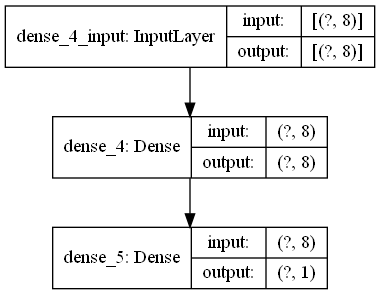

In [56]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Compilando e treinando o modelo. 
### Vamos utilizar a função de Callback ModelCheckPointer para salvar o modelo com a melhor accuracia na base de validação (que é a mesma de teste final pois temos uma base muito pequena)

In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', get_f1])

In [58]:
%%time
checkpointer = ModelCheckpoint_tweaked(filepath='./modelo_mlp_ex3_3.hdf5', verbose=1,  mode='max', save_best_only=True, monitor='val_get_f1')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[checkpointer])

Epoch 1/100
151/164 [==========================>...] - ETA: 0s - loss: 0.6010 - accuracy: 0.8142 - get_f1: 0.6846
Epoch 00001: val_get_f1 improved from -inf to 0.92714, saving model to .\modelo_mlp_ex3_3.hdf5
164/164 [==============================] - 1s 4ms/step - loss: 0.5948 - accuracy: 0.8227 - get_f1: 0.7039 - val_loss: 0.5147 - val_accuracy: 0.9387 - val_get_f1: 0.9271
Epoch 2/100
154/164 [===========================>..] - ETA: 0s - loss: 0.4548 - accuracy: 0.9209 - get_f1: 0.9135
Epoch 00002: val_get_f1 did not improve from 0.92714
164/164 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.9223 - get_f1: 0.9152 - val_loss: 0.3916 - val_accuracy: 0.9372 - val_get_f1: 0.9254
Epoch 3/100
154/164 [===========================>..] - ETA: 0s - loss: 0.3512 - accuracy: 0.9168 - get_f1: 0.9082
Epoch 00003: val_get_f1 did not improve from 0.92714
164/164 [==============================] - 0s 2ms/step - loss: 0.3506 - accuracy: 0.9165 - get_f1: 0.9053 - val_loss: 0

## Gráfico comparativo da Acurácia , F1 Score e Perda no treinamento

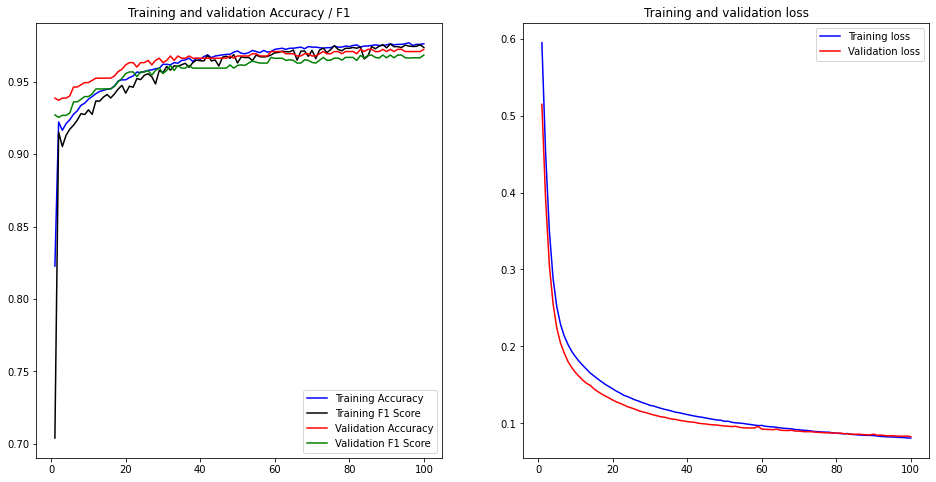

In [59]:
plot_history(history)

## Carregando o melhor modelo salvo e apresentando a acurácia do Treino e do Teste

In [61]:
model = load_model("./modelo_mlp_ex3_3.hdf5", custom_objects={'get_f1': get_f1})

In [62]:
scores = model.evaluate(X_train, y_train)
print()
print(f"F1 Score do Treino: {round(scores[2]*100,2)}%")

82/82 [==============================] - 0s 2ms/step - loss: 0.0845 - accuracy: 0.9751 - get_f1: 0.9738

F1 Score do Treino: 97.38%


In [63]:
scores = model.evaluate(X_test, y_test)
print()
print(f"F1 Score da Validação: {round(scores[2]*100,2)}%")

21/21 [==============================] - 0s 2ms/step - loss: 0.0861 - accuracy: 0.9724 - get_f1: 0.9714

F1 Score da Validação: 97.14%


## Conferindo o modelo final com uma Validação Cruzada (Cross Validation) usando 10 amostras. Neste caso vamos usar toda a base de dados.

In [27]:
def create_model():
    model = Sequential()
    model.add(Dense(8, input_dim=num_features, activation='relu'))
    model.add(Dense(1 , activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    

In [29]:
estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=16, verbose=0)
scores = cross_val_score(estimator, X, y, cv=10, n_jobs=1)
print("Accuracy : {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))

KeyboardInterrupt: 